# Evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import optim
from models import pursuer_NN

from random import sample

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

3.9.7 (default, Sep 10 2021, 14:59:43) 
[GCC 11.2.0]
1.9.1+cu111
11.1
cuda


## Environment

In [2]:
from environment import Environment

sel_env = 3
res = 1

env_file = open('Env'+str(sel_env)+'_res'+str(res)+'.txt', 'r')
env_head = np.fromstring(env_file.readline(), dtype=np.int32, sep=' ')
env_file.close()

env = Environment(env_head, device)
print('Max reward', env.t_end+1)

Max reward 101


## Random Initial states

In [3]:
initial_states = env.test_configurations(10, 3.)
print(len(initial_states))

500


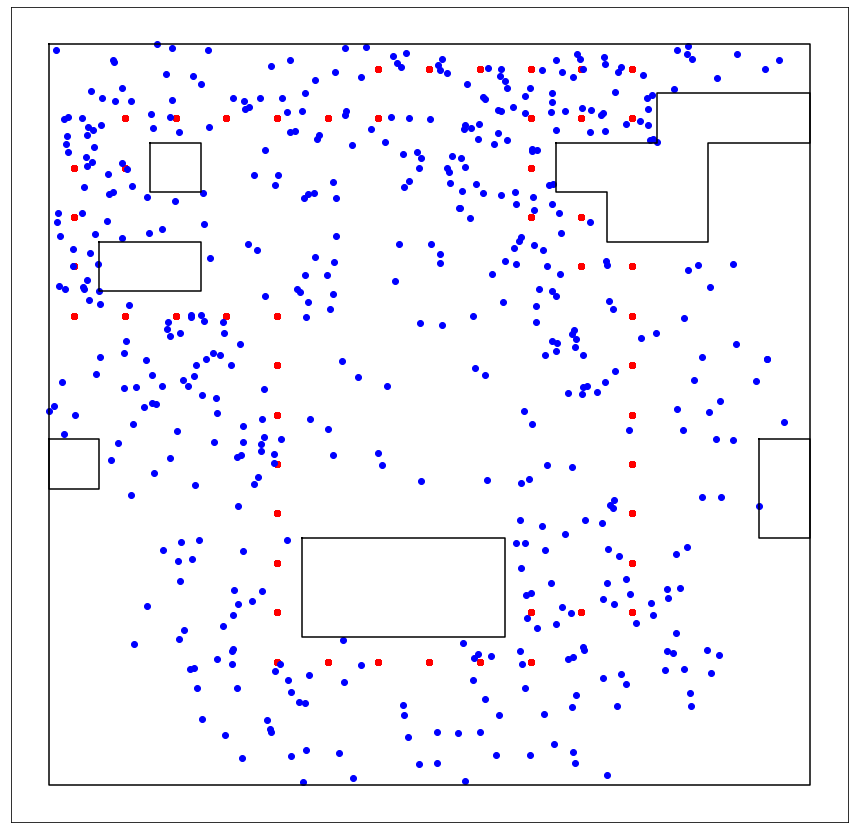

In [4]:
from obstacles import obstacles_per_env, border_per_env
border = border_per_env(sel_env)
obs = obstacles_per_env(sel_env)

border_x = []
border_y = []
for ver in border.vertices:
    border_x.append(ver.y)
    border_y.append(-ver.x)
border_x.append(border.vertices[0].y)
border_y.append(-border.vertices[0].x)

initial_states_array = np.array(initial_states)

ey = -initial_states_array[:,0]
ex = initial_states_array[:,1]
py = -initial_states_array[:,2]
px = initial_states_array[:,3]

if sel_env == 3: plt.figure(figsize=(15,15))
plt.scatter(ex, ey, c='red')
plt.scatter(px, py, c='blue')

plt.plot(border_x, border_y, 'k')
for ob in obs:
    ob_x = []
    ob_y = []
    
    for ver in ob.vertices:
        ob_x.append(ver.y)
        ob_y.append(-ver.x)
    ob_x.append(ob.vertices[0].y)
    ob_y.append(-ob.vertices[0].x)

    plt.plot(ob_x, ob_y, 'k')
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.savefig('evaluation_samples' + str(sel_env) + '.png')
plt.show()

## Create fully connected network

In [5]:
pursuer_SMP = torch.load('pursuer_NN_Env'+str(sel_env)+'_res'+str(res)+'.pt').to(device)
pursuer_SMP.eval()

pursuer_RMP = torch.load('pursuer_RL_Env' + str(sel_env) + '.pt').to(device)
pursuer_RMP.eval()

pursuer_IRMP = torch.load('pursuer_RL_Env' + str(sel_env) + '_initialization.pt').to(device)
pursuer_IRMP.eval()

pursuer_MRMP = torch.load('pursuer_RL_Env' + str(sel_env) + '_master.pt').to(device)
pursuer_MRMP.eval()

pursuer_NN(
  (predict): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=5, bias=True)
    (9): Softmax(dim=-1)
  )
)

In [6]:
def escape_lens(policy):
    sizeSample = len(initial_states)
    escapes = np.zeros(sizeSample)

    for i in range(sizeSample):
        s_0 = initial_states[i]
        env.set_state(s_0)
        done = False
        t = 0
        while not done:
            p_dist = policy(s_0).detach().cpu().numpy()
            s_0, r, done, _ = env.step_best_action(p_dist, t)
            escapes[i] += r
            t += 1

        print('\rstate {} out of {}'.format(i+1, sizeSample), end='')
    print('')    

    return escapes

In [7]:
SMP_escapes  = escape_lens(pursuer_SMP)
print('done 1')
RMP_escapes  = escape_lens(pursuer_RMP)
print('done 2')
IRMP_escapes = escape_lens(pursuer_IRMP)
print('done 3')
MRMP_escapes = escape_lens(pursuer_MRMP)
print('done 4')

state 500 out of 500
done 1
state 500 out of 500
done 2
state 500 out of 500
done 3
state 500 out of 500
done 4


In [8]:
# Save results
np.savetxt('SMP'+str(sel_env)+'.txt', SMP_escapes, fmt='%d')
np.savetxt('RMP'+str(sel_env)+'.txt', RMP_escapes, fmt='%d')
np.savetxt('IRMP'+str(sel_env)+'.txt', IRMP_escapes, fmt='%d')
np.savetxt('MRMP'+str(sel_env)+'.txt', MRMP_escapes, fmt='%d')

np.savetxt('eval_states' + str(sel_env) + '.txt', initial_states_array, fmt='%.2f')

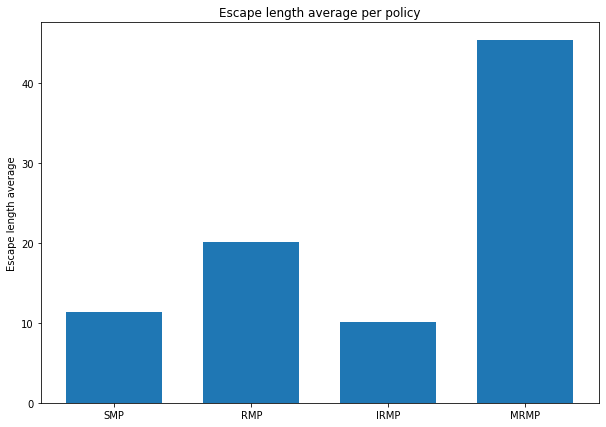

In [9]:
#x = np.linspace(0,3,4)
x = ['SMP', 'RMP', 'IRMP', 'MRMP']
y = [np.mean(SMP_escapes), np.mean(RMP_escapes), np.mean(IRMP_escapes), np.mean(MRMP_escapes)]
plt.figure(figsize=(10,7))
plt.bar(x, height=y, width=0.7)
plt.title('Escape length average per policy')
plt.ylabel('Escape length average')
plt.savefig('eval_rewards_average_' + str(sel_env) + '.png')
plt.show()

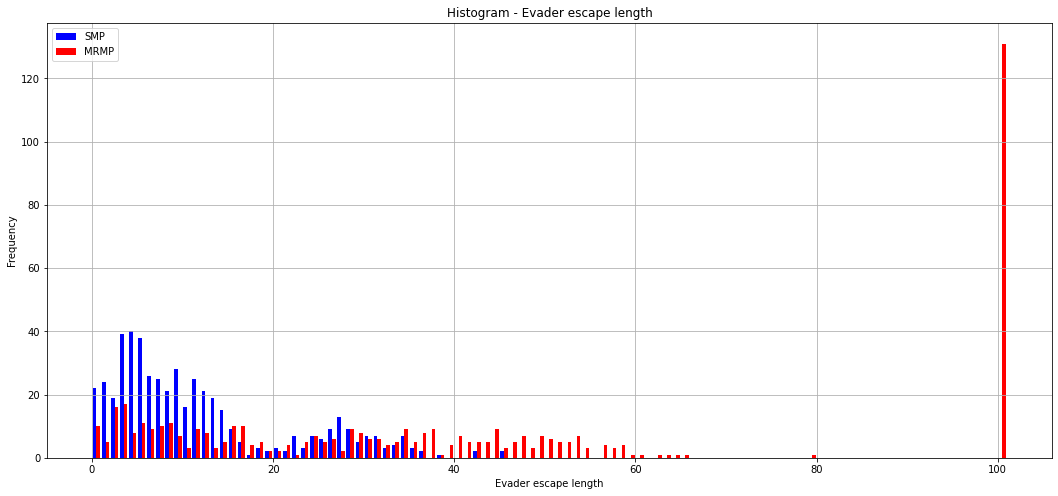

In [10]:
max_bin = max(max(SMP_escapes), max(RMP_escapes), max(IRMP_escapes), max(MRMP_escapes))
min_bin = min(min(SMP_escapes), min(RMP_escapes), min(IRMP_escapes), min(MRMP_escapes))
plt.figure(figsize=(18,8))

plt.hist([SMP_escapes, MRMP_escapes], 
        bins=int(max_bin-min_bin), 
        label=['SMP', 'MRMP'],
        color=['blue', 'red'])

plt.legend()
plt.title('Histogram - Evader escape length')
plt.xlabel('Evader escape length')
plt.ylabel('Frequency')
plt.grid()
plt.savefig('SMPvsMRMP' + str(sel_env) + '.png')

plt.show()

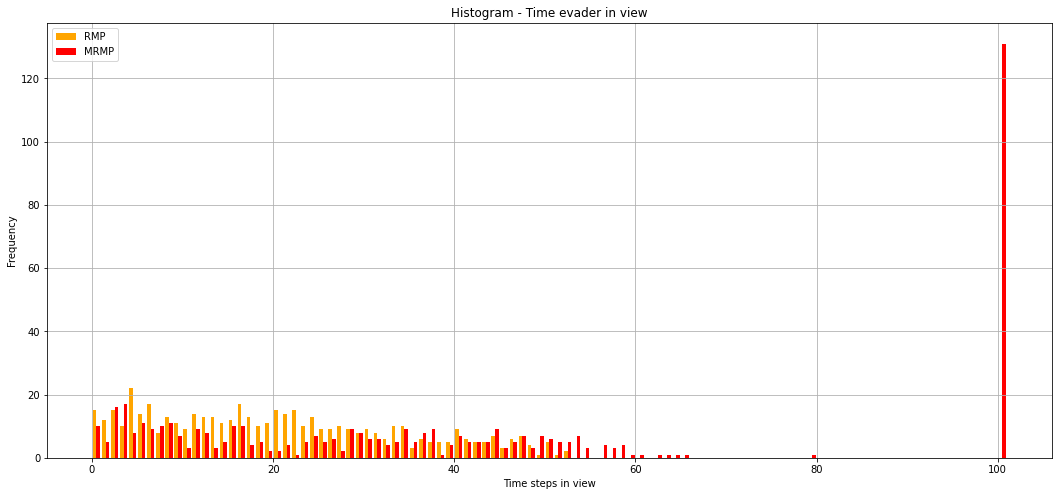

In [11]:
plt.figure(figsize=(18,8))
plt.hist([RMP_escapes, MRMP_escapes], 
        bins=int(max_bin-min_bin), 
        label=['RMP', 'MRMP'],
        color=['orange', 'red'])

plt.legend()
plt.title('Histogram - Time evader in view')
plt.xlabel('Time steps in view')
plt.ylabel('Frequency')
plt.grid()
plt.savefig('RMPvsMRMP' + str(sel_env) + '.png')

plt.show()

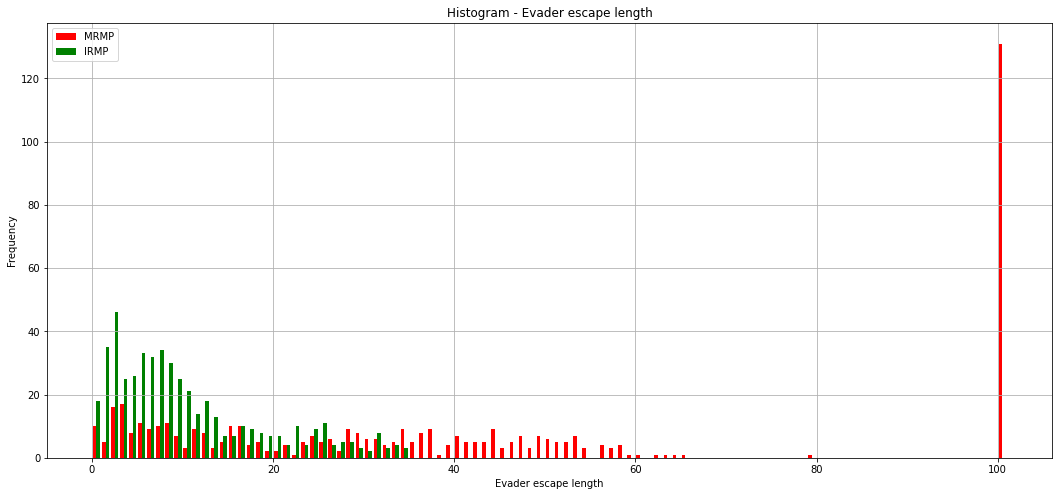

In [12]:
plt.figure(figsize=(18,8))
plt.hist([MRMP_escapes, IRMP_escapes], 
        bins=int(max_bin-min_bin), 
        label=['MRMP', 'IRMP'],
        color=['red', 'green'])

plt.legend()
plt.title('Histogram - Evader escape length')
plt.xlabel('Evader escape length')
plt.ylabel('Frequency')
plt.grid()
plt.savefig('IRMPvsMRMP' + str(sel_env) + '.png')
plt.show()

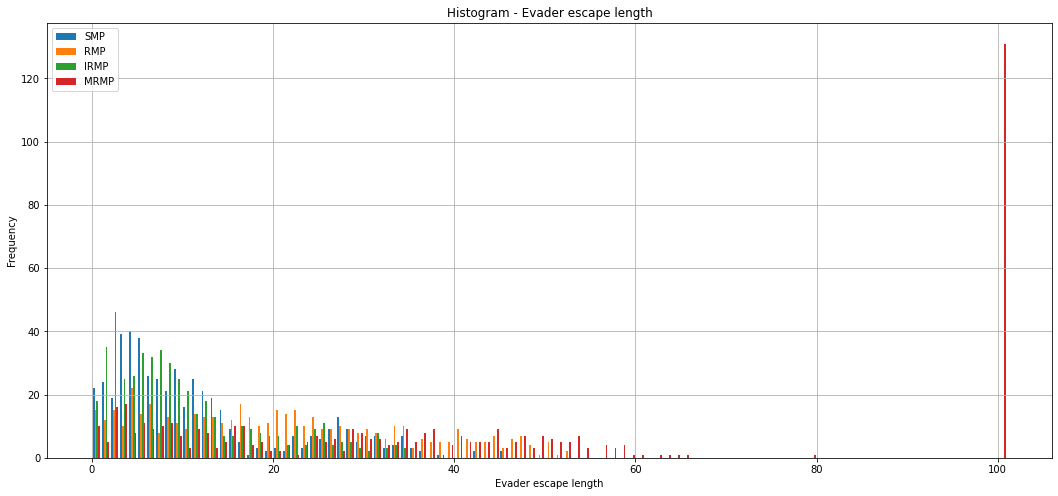

In [13]:
plt.figure(figsize=(18,8))
plt.hist([SMP_escapes, RMP_escapes, IRMP_escapes, MRMP_escapes], 
        bins=int(max_bin-min_bin), 
        label=['SMP', 'RMP', 'IRMP', 'MRMP'])

# plt.hist(SCMP_escapes, bins=int((max(SCMP_escapes) - min(SCMP_escapes))), alpha=0.5, label='SCMP')
# plt.hist(RCMP_escapes, bins=int((max(RCMP_escapes) - min(RCMP_escapes))), alpha=0.5, label='RCMP')
# plt.hist(IRCMP_escapes, bins=int((max(IRCMP_escapes) - min(IRCMP_escapes))), alpha=0.5, label='IRCMP')
# plt.hist(MRCMP_escapes, bins=int((max(MRCMP_escapes) - min(MRCMP_escapes))), alpha=0.5, label='MRCMP')
plt.legend()
plt.title('Histogram - Evader escape length')
plt.xlabel('Evader escape length')
plt.ylabel('Frequency')
plt.grid()
plt.savefig('SMPvsRMPvsIRMPvsMRMP' + str(sel_env) + '.png')
plt.show()